# Contents
1. Importing libraries
2. Loading API key
3. Getting data from St. Louis Fed (FRED)
4. Visualizing data
5. Cleaning data
6. Decomposition
7. Testing for Stationarity and Autocorrelation
8. Stationarizing the data

### 1. Importing libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 
from dotenv import load_dotenv
warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight') 

### 2. Loading API key

In [2]:
# Configure API key 
load_dotenv()
api_key = os.environ.get('fred_key')

### 3. Getting data from St. Louis Fed (FRED)

I chose the All-Transactions House Price Index for the United States for time-series analysis. It is a measure of the changes in housing prices over time. 

In [3]:
# Define the FRED API endpoint
base_url = 'https://api.stlouisfed.org/fred/'

In [4]:
# Assign endpoint
obs_endpoint = 'series/observations'

In [5]:
# Assign parameters
series_id = 'USSTHPI'
start_date = '2002-01-01'
end_date = '2022-12-31'
ts_frequency = 'a'

In [6]:
obs_params = {
    'series_id': series_id,
    'api_key': api_key,
    'file_type': 'json',
    'observation_start': start_date,
    'observation_end': end_date,
    'frequency': ts_frequency
}

I set the start and end dates in the extraction. No filtering will be necessary in a later step.

In [7]:
# Make request to FRED API
response = requests.get(base_url + obs_endpoint, params=obs_params)

In [8]:
# Format data
if response.status_code == 200:
    res_data = response.json()
    obs_data = pd.DataFrame(res_data['observations'])
    obs_data['date'] = pd.to_datetime(obs_data['date'])
    obs_data.set_index('date', inplace=True)
    obs_data['value'] = obs_data['value'].astype(float)

else:
    print('Failed to retrieve data. Status code:', response.status_code)

I set the date as the index in this step. I will not need to use the date for filtering, so this should not have to change. 

In [9]:
obs_data.head()

,realtime_start,realtime_end,value
date,,,
2002-01-01,2024-04-07,2024-04-07,269.75
2003-01-01,2024-04-07,2024-04-07,286.57
2004-01-01,2024-04-07,2024-04-07,313.42
2005-01-01,2024-04-07,2024-04-07,348.99
2006-01-01,2024-04-07,2024-04-07,374.00


In [10]:
obs_data.shape

(21, 3)

The realtime fields show when the data was accessed. They are object fields and are not necessary for analysis. I will subset to remove them.

In [19]:
obs_data_sub = obs_data[['value']]

In [20]:
obs_data_sub

,value
date,
2002-01-01,269.75
2003-01-01,286.57
2004-01-01,313.42
2005-01-01,348.99
2006-01-01,374.00
2007-01-01,378.14
2008-01-01,358.72
2009-01-01,338.81
2010-01-01,324.99


### 4. Visualizing data

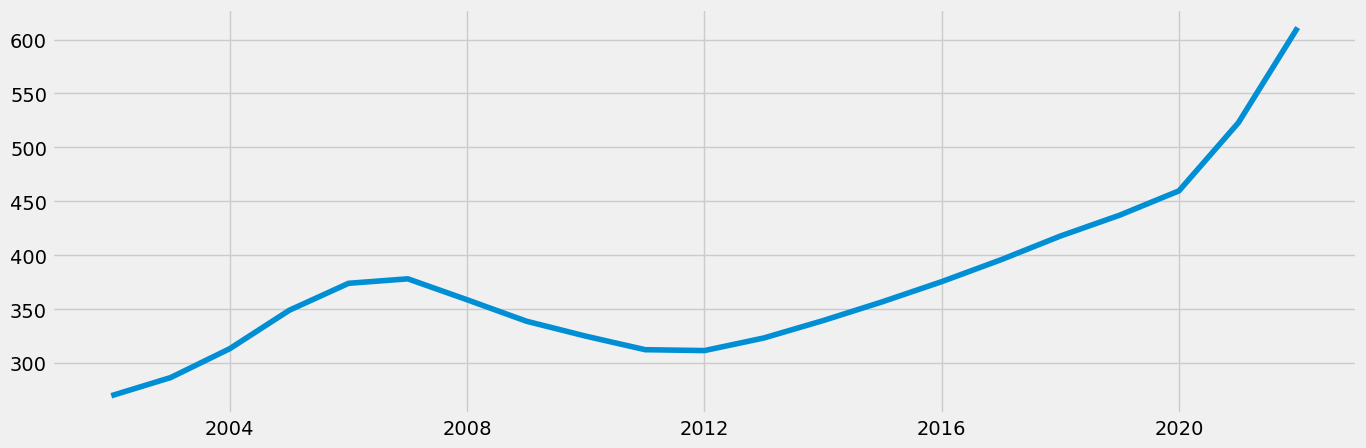

In [21]:
#obs_data.plot()
# Plot the data using matplotlib.

plt.figure(figsize=(15,5))
plt.plot(obs_data_sub)

### 5. Cleaning data

In [24]:
# Check for missing values 
obs_data_sub.isnull().sum() 

value    0
dtype: int64

In [25]:
# Check for duplicates
dups = obs_data_sub.duplicated()
dups.sum()

0

No missing values or duplicates.

### 6. Decomposition

In [26]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(obs_data_sub, model='additive')

In [27]:
from pylab import rcParams # This will define a fixed size for all special charts.
rcParams['figure.figsize'] = 18, 7

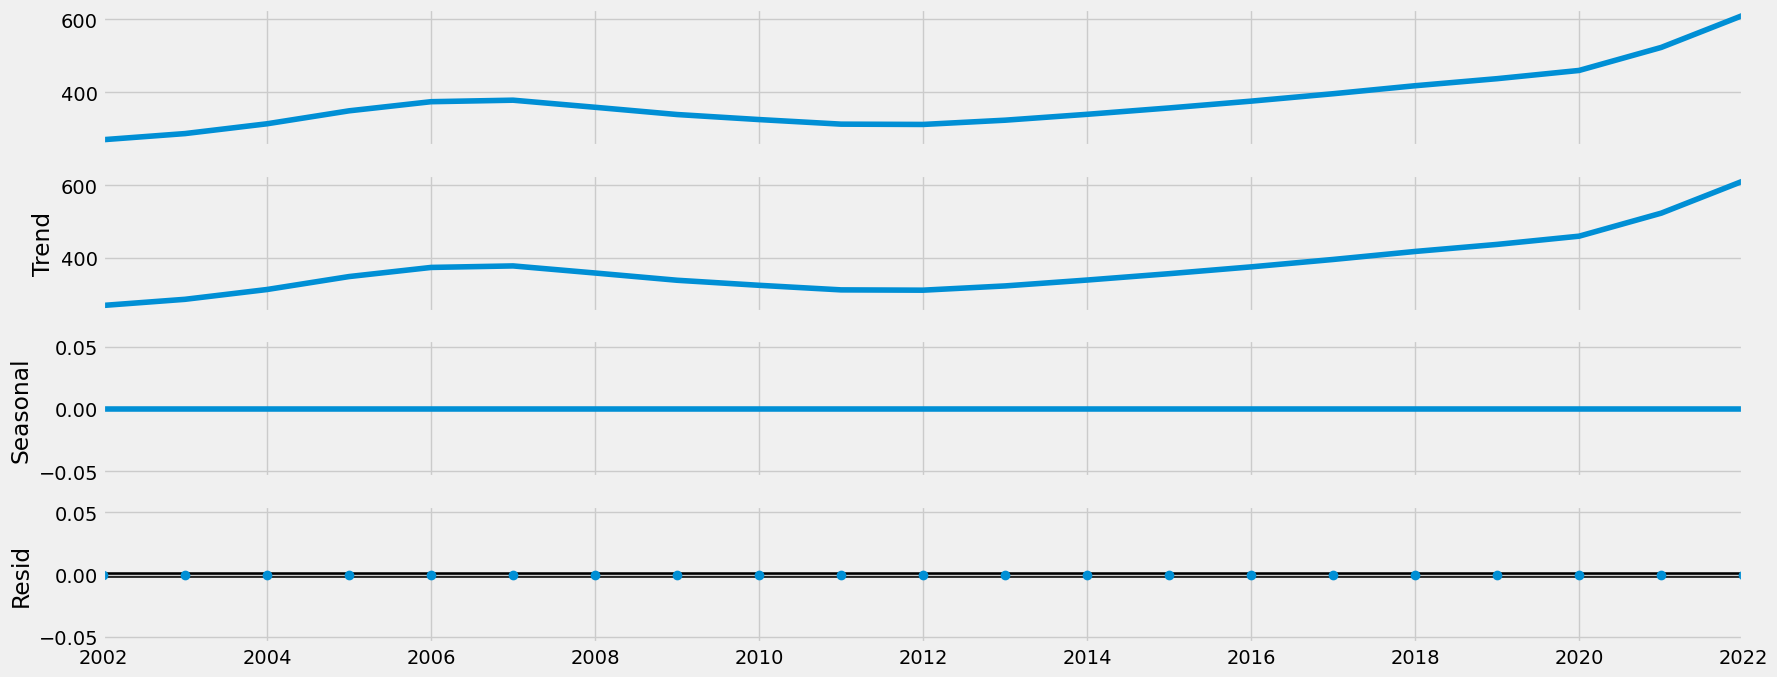

In [28]:
# Plot the separate components
decomposition.plot()
plt.show()

There is a clear trend over time. There is no seasonality, which is not surprising. I chose annual increments. There is also no noise, which is also not surprising. This data is from an index that was calculated to eliminate noise. 

### 7. Testing for Stationarity and Autocorrelation

In [30]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(obs_data_sub['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  3.704636
p-value                         1.000000
Number of Lags Used             8.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


The test statistic is greater than the Critical Value (at all levels of confidence), which means the null hypothesis can't be ruled out. The data is not stationary. However, the result is not significant considering the p-value is greater than 0.05. 

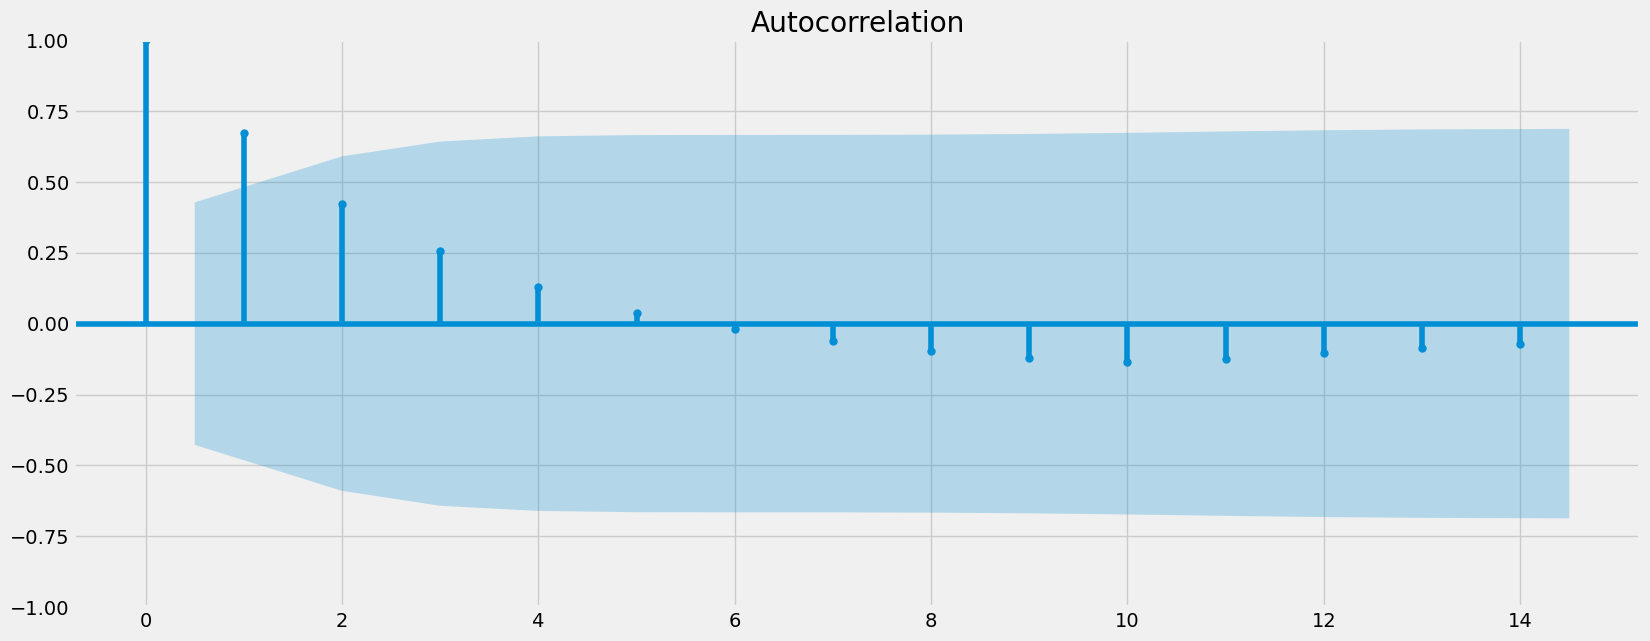

In [31]:
# Autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots
plot_acf(obs_data_sub)
plt.show()

The autocorrelation testing shows only one lag above the confidence level. This does not confirm the Dickey-Fuller test. 

### 8. Stationarizing the data

In [32]:
data_diff = obs_data_sub - obs_data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [33]:
data_diff.dropna(inplace = True) # removing any missing values due to differencing.

In [34]:
data_diff.head()

,value
date,
2003-01-01,16.82
2004-01-01,26.85
2005-01-01,35.57
2006-01-01,25.01
2007-01-01,4.14


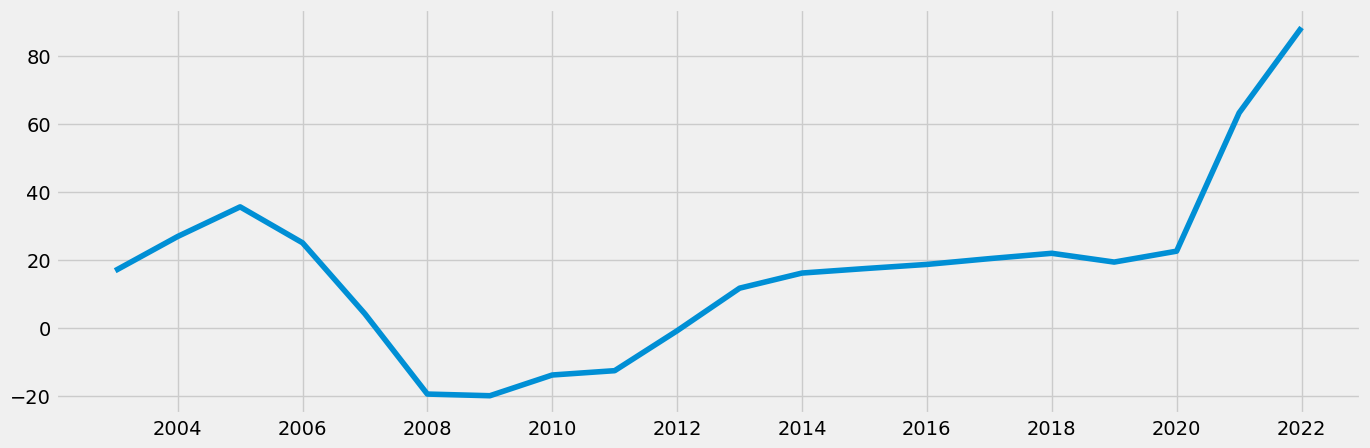

In [35]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [36]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  5.545601
p-value                         1.000000
Number of Lags Used             8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


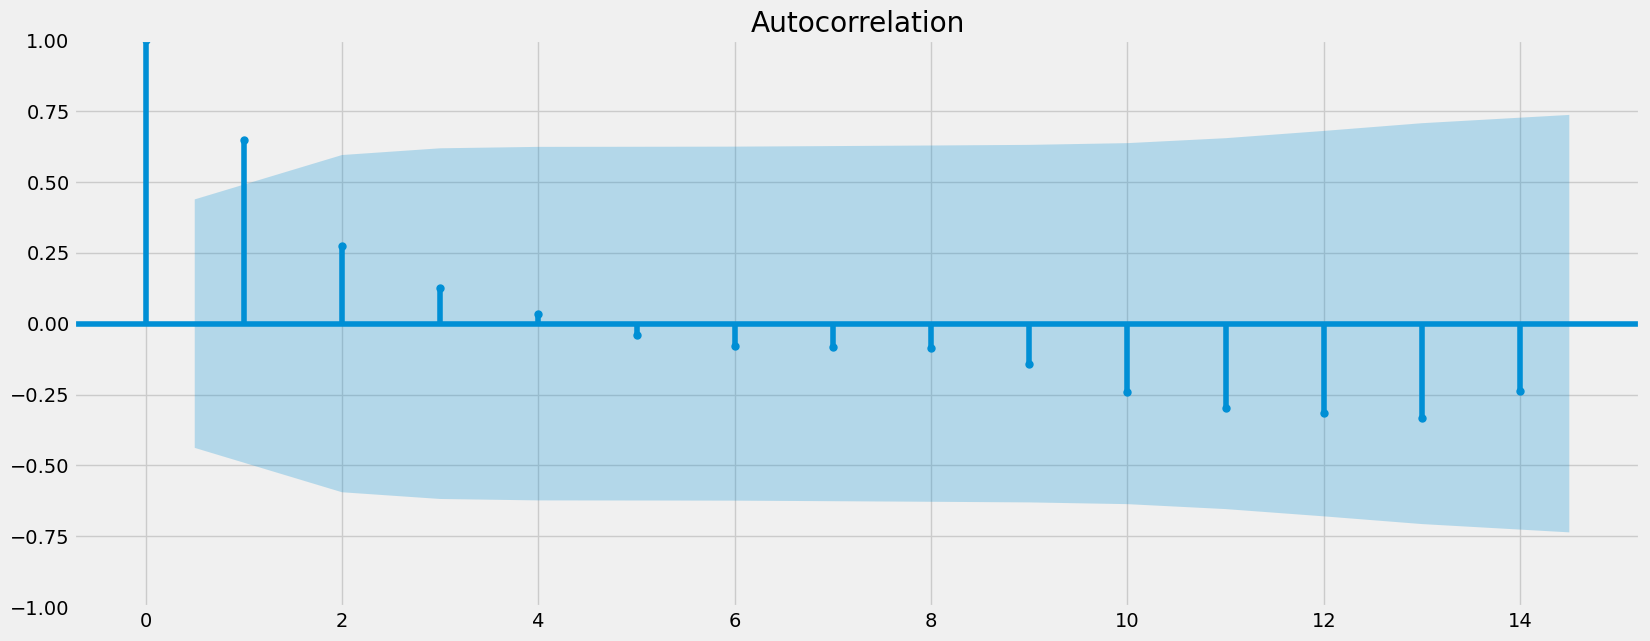

In [37]:
plot_acf(data_diff)
plt.show()

The attempt at stationarizing  the data had no effect. Both the Dickey Fuller test and the autocorrelation test are very similar to the same visualizations prior to the attempt. 